In [6]:
# Common imports
import pandas as pd

import os
from ImageAnnotation import ImageAnnotation, synset_to_word

In [8]:
FILE_TYPES = dict([
    ("train","train"),
    ("test","test"),
    ("val","val")
])

current_imagesets_file = 1
train_imagesets_size = 200


class Dataset:
    def __init__(self, root_dir='/notebooks/dataset/'):
        # Data Directory
        self.data_dir = os.path.join(root_dir, 'Data', 'DET')
        self.test_data = os.path.join(self.data_dir, 'test')
        self.train_data = os.path.join(self.data_dir, 'train')
        self.val_data = os.path.join(self.data_dir, 'val')
        
        # Annotations Directory
        self.ann_dir = os.path.join(root_dir, 'Annotations', 'DET')
        self.train_ann = os.path.join(self.ann_dir, 'train')
        self.val_ann = os.path.join(self.ann_dir, 'val')        
        
        # ImageSet Directory
        self.set_dir = os.path.join(root_dir, 'ImageSets', 'DET')
    
        # Batching
        self.current_train_set_index = 1 # current imagesets training file
        self.current_val_set_index = 1 # current imagesets Validation file
        
        # ImageSet files and batch indices 
        # I will start the indices for the imagesets at one for consistency.
        # So the range would be [1-N] where "N = the batch size or file index"
        # This will make sense when I implement "getBatch", I recommend taking
        # a look at the implementation to make sense of it, hopefully, haha.
        self.train_imageset_batch_index = 1
        self.val_imageset_batch_index = 1
        self.test_imageset_file = self.getImageSetFile(type=FILE_TYPES['test'])
        self.train_imageset_file = self.getImageSetFile(self.train_imageset_batch_index, 
                                                          type=FILE_TYPES['train'])
        self.val_imageset_file = self.getImageSetFile(self.val_imageset_batch_index, 
                                                        type=FILE_TYPES['val'])

    def getBatch(self, batch_size=64, test=False):
        """
        To-Do:
        
        Args:
            batch_size (int): The number of items in the array. 
            test (bool): Dictates if we should return test data or train data.
        
        Return:
            train_file_buffer (Array(ImageAnnotation)) and val_file_buffer 
            (Array(ImageAnnotation)) of size batch_size if test=False. 
            Otherwise, return test_file_buffer (Array(ImageAnnotation)) 
            of size batch_size .
        """
        test_ann_buffer = []
        train_ann_buffer = []
        val_ann_buffer = []        
        
        if (test):
            # To-Do: Some test
            for _ in range(batch_size):
                test_annotation = self.getAnnotation(self.test_imageset_file.readline())

                # Do some eval of the lines make sure it's not EOF
                if not test_annotation:
                    # We are done with this file, lets close it
                    self.test_imageset_batch_index += 1
                    # Read next file if avalable 
                    self.test_imageset_file.close()
                    self.test_imageset_file = self.getImageSetFile(type=FILE_TYPES['test'])
                    break
                    
                test_ann_buffer.append(test_annotation)

            return(test_ann_buffer)
        
        for _ in range(batch_size):
            train_annotation = self.getAnnotation(self.train_imageset_file.readline(), 
                                                  type=FILE_TYPES['train'])
            val_annotation = self.getAnnotation(self.val_imageset_file.readline(), 
                                                type=FILE_TYPES['val'])
            
            # Do some eval of the lines make sure it's not EOF
            if not train_annotation:
                # We are done with this file, lets close it
                self.train_imageset_batch_index += 1
                # Read next file if avalable
                self.train_imageset_file.close()
                self.train_imageset_file = self.getImageSetFile(self.train_imageset_batch_index, 
                                                                  type=FILE_TYPES['train'])
                train_annotation = self.getAnnotation(self.train_imageset_file.readline())
                
            if not val_annotation:
                # We are done with this file, lets close it
                self.val_imageset_file.close()      
                # Read next file if avalable
                self.val_imageset_batch_index += 1
                self.val_imageset_file = self.getImageSetFile(self.val_imageset_batch_index, 
                                                      type=FILE_TYPES['val'])
                val_annotation = self.getAnnotation(self.val_imageset_file.readline(),
                                                    type=FILE_TYPES['val'])
                
            # If everything checks out, create a new annotation
            # object for both the train and validation set.
            train_ann_buffer.append(train_annotation)
            val_ann_buffer.append(val_annotation)
                
        return(train_ann_buffer, val_ann_buffer)
        
    def getImageSetFile(self, file_index=1, type=FILE_TYPES['train']):
        if FILE_TYPES['train'] in type:
            if (file_index > train_imagesets_size) or (file_index <= 0):
                self.train_imageset_batch_index = 1
                return open(os.path.join(self.set_dir , 'train_1.txt'), 'r')
            else:
                return open(os.path.join(self.set_dir , 
                                         'train_{}.txt'.format(file_index)), 'r')
        elif FILE_TYPES['test'] in type:
            # There is only 1 test file
            return open(os.path.join(self.set_dir , 'test.txt'), 'r')
        else:
            if (file_index > 2) or (file_index <= 0):
                self.val_imageset_batch_index = 0
                return open(os.path.join(self.set_dir , 'val.txt'), 'r')
            else:
                return open(os.path.join(self.set_dir , 
                                         'val{}.txt'.format(file_index)), 'r')
        
    def getImageSetURI(self, image_set_line="", type=FILE_TYPES["train"]):
        """
        Args:
            image_set_line (str): a line from the ImageSets directory files. 
                This line contains the following format: 
                    
                    '<dir>/<filename>\ <number>'

        Returns:
            Full path to the ImageSet given a line from the ImageSets directory files. 
            If the image_set_line is empty, return None.
        """        
        if image_set_line.strip():
            imgset_relative_path = image_set_line.split(" ")[0]
            return(os.path.join(self.ann_dir, 
                                type, 
                                imgset_relative_path))
        
        return None
            
    def getAnnotation(self, image_set_line="", type=FILE_TYPES["train"]):
        uri = self.getImageSetURI(image_set_line, type)
        
        if uri and not ("extra" in uri):
            return ImageAnnotation("{}.xml".format(uri))
        
        return None
    
    def getDataURI(self, image_set_line="", type=FILE_TYPES["train"]):
        uri = self.getImageSetURI(image_set_line, type)
        
        if uri:
            return "{}.JPEG".format(uri)
        
        return None
        
    def cleanup(self):
        self.test_imageset_file.close()
        self.train_imageset_file.close()
        self.val_imageset_file.close()
        
            

In [9]:
dataset = Dataset()

In [10]:
for i in range(8800):
    train_ann, val_ann = dataset.getBatch(10)

    if (i % 800) == 0:
            print("{} lines read".format(i * 10))

            for annotation in train_ann:
                print(annotation.data_uri)

0 lines read
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00002439.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00007703.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0001/ILSVRC2014_train_00014926.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0001/ILSVRC2014_train_00016907.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0002/ILSVRC2014_train_00020156.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0002/ILSVRC2014_train_00022776.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0002/ILSVRC2014_train_00026670.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0002/ILSVRC2014_train_00029758.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0002/ILSVRC2014_train_00029811.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0002/ILSVRC2014_train_00029838.JPEG
8000 lines read
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00007210.JPEG
/notebooks/dat

72000 lines read
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009232.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009233.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009234.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009235.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009236.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009237.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009238.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009239.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009240.JPEG
/notebooks/dataset/Data/DET/train/ILSVRC2014_train_0000/ILSVRC2014_train_00009241.JPEG
Is none
This is the line = 
We need to update the file.
Now reading file valfile number 1
80000 lines read
/noteb

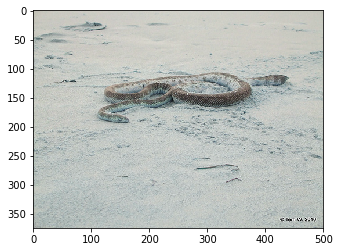

In [28]:
print(dataset.getAnnotation("ILSVRC2012_val_00000001", type=FILE_TYPES['val']))
dataset.getAnnotation("ILSVRC2012_val_00000001", type=FILE_TYPES['val']).show()